In [1]:
# uv pip install torch transformers numpy

In [1]:
# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Model imports
from model import SmartContractTransformer

# Training imports
from train import SmartContractTrainer

# Optional but useful imports
import numpy as np
from tqdm import tqdm  # for progress bars
import logging 


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.11/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.11/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/home/m20180848/pytorch_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/m20180848/pytorch_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/m20180848/pytorch_env

In [2]:
from transformers import AutoTokenizer
import json
import os
import pandas as pd
from typing import Dict, List, Tuple, Any
import re

- Dataset.py script:

In [3]:
print(f"CUDA is available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

CUDA is available: True
Number of GPUs: 2


In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def parse_solidity_to_ast(code: str) -> Dict[str, Any]:
    """
    Parse Solidity code into a simplified AST structure
    """
    def extract_contract_info(code: str) -> Dict[str, Any]:
        # Extract contract name
        contract_match = re.search(r'contract\s+(\w+)', code)
        contract_name = contract_match.group(1) if contract_match else "Unknown"
        
        # Extract functions
        functions = []
        function_pattern = r'function\s+(\w+)\s*\(([^)]*)\)\s*(?:public|private|internal|external)?\s*(?:view|pure|payable)?\s*(?:returns\s*\(([^)]*)\))?\s*{'
        for match in re.finditer(function_pattern, code):
            func_name = match.group(1)
            params = match.group(2).split(',') if match.group(2) else []
            returns = match.group(3).split(',') if match.group(3) else []
            
            functions.append({
                'name': func_name,
                'parameters': [p.strip() for p in params],
                'returns': [r.strip() for r in returns]
            })
        
        # Extract state variables
        variables = []
        var_pattern = r'(?:uint|address|string|bool|mapping)\s+(?:\w+)\s+(\w+)'
        for match in re.finditer(var_pattern, code):
            variables.append(match.group(1))
        
        return {
            'type': 'Contract',
            'name': contract_name,
            'functions': functions,
            'variables': variables
        }
    
    try:
        # Clean the code
        code = re.sub(r'//.*?\n|/\*.*?\*/', '', code)  # Remove comments
        code = re.sub(r'\s+', ' ', code)  # Normalize whitespace
        
        # Parse the code
        ast = extract_contract_info(code)
        return ast
    except Exception as e:
        print(f"Error parsing code: {str(e)}")
        return None

def prepare_code2vec_input(ast: Dict[str, Any]) -> List[str]:
    """
    Convert AST to codeBert input format
    """
    paths = []
    
    def extract_paths(node: Dict[str, Any], current_path: List[str] = None):
        if current_path is None:
            current_path = []
            
        # Add current node to path
        if 'name' in node:
            current_path.append(node['name'])
            
        # Process functions
        if 'functions' in node:
            for func in node['functions']:
                func_path = current_path + [func['name']]
                paths.append(' '.join(func_path))
                
                # Add parameter paths
                for param in func['parameters']:
                    param_path = func_path + [param]
                    paths.append(' '.join(param_path))
                
                # Add return paths
                for ret in func['returns']:
                    ret_path = func_path + [ret]
                    paths.append(' '.join(ret_path))
        
        # Process variables
        if 'variables' in node:
            for var in node['variables']:
                var_path = current_path + [var]
                paths.append(' '.join(var_path))
    
    extract_paths(ast)
    return paths

class SmartContractVulnerabilityDataset(Dataset):
    def __init__(
        self,
        data_path: str,
        tokenizer: AutoTokenizer,
        max_length: int = 1024,
        split: str = "train",
        vulnerability_types: List[str] = None
    ):
        """
        Args:
            data_path: Path to the CSV file containing the dataset
            tokenizer: Tokenizer for encoding the source code
            max_length: Maximum sequence length
            split: "train" or "val" to specify which split to load
            vulnerability_types: List of vulnerability types to consider
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.split = split
        self.vulnerability_types = vulnerability_types or [
            'ARTHM', 'DOS', 'LE', 'RENT', 'TimeM', 'TimeO', 'Tx-Origin', 'UE'
        ]
        
        # Load the dataset
        self.data = self._load_dataset(data_path)
        
    def _load_dataset(self, data_path: str) -> List[Dict]:
        """Load and preprocess the dataset from CSV"""
        dataset = []
        
        # Read the CSV file
        df = pd.read_csv(data_path)
        
        # Split into train/val if needed
        if self.split == "train":
            df = df.sample(frac=0.8, random_state=42)
        else:
            df = df.sample(frac=0.2, random_state=42)
        
        # Process each contract
        for _, row in df.iterrows():
            try:
                source_code = row['source_code']
                contract_name = row['contract_name']
                
                # Parse AST and get paths
                ast = parse_solidity_to_ast(source_code)
                ast_paths = prepare_code2vec_input(ast) if ast else []
                ast_path_text = ' '.join(ast_paths)
                
                # Split source code into lines
                lines = source_code.split('\n')
                
                # Create token-to-line mapping
                token_to_line = []
                current_line = 0
                
                # Tokenize each line separately to maintain mapping
                for line in lines:
                    line_tokens = self.tokenizer.encode(line, add_special_tokens=False)
                    token_to_line.extend([current_line] * len(line_tokens))
                    current_line += 1
                
                # Add special tokens
                token_to_line = [0] + token_to_line + [0]  # [CLS] and [SEP] tokens
                
                # Truncate if too long
                if len(token_to_line) > self.max_length:
                    token_to_line = token_to_line[:self.max_length]
                
                # Pad if too short
                if len(token_to_line) < self.max_length:
                    token_to_line.extend([0] * (self.max_length - len(token_to_line)))
                
                # Create multi-label line labels for each vulnerability type
                line_labels = self._create_multi_label_line_labels(source_code, row)
                
                # Create contract-level vulnerability labels
                contract_labels = self._create_contract_vulnerability_labels(row)
                
                # Tokenize the source code
                encoding = self.tokenizer(
                    source_code,
                    max_length=self.max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                
                # Tokenize AST paths
                ast_encoding = self.tokenizer(
                    ast_path_text,
                    max_length=self.max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                
                # Convert line labels to tensor and ensure consistent shape
                vuln_tensor = torch.zeros((len(self.vulnerability_types), self.max_length), dtype=torch.long)
                for i, labels in enumerate(line_labels):
                    if len(labels) > self.max_length:
                        labels = labels[:self.max_length]
                    vuln_tensor[i, :len(labels)] = torch.tensor(labels, dtype=torch.long)
                
                # Convert contract labels to tensor
                contract_vuln_tensor = torch.tensor(contract_labels, dtype=torch.long)
                
                # Convert token_to_line to tensor
                token_to_line_tensor = torch.tensor(token_to_line, dtype=torch.long)
                
                # Ensure attention masks are boolean
                attention_mask = encoding['attention_mask'].squeeze(0).bool()
                ast_attention_mask = ast_encoding['attention_mask'].squeeze(0).bool()
                
                # Ensure input_ids are the right length
                input_ids = encoding['input_ids'].squeeze(0)
                ast_input_ids = ast_encoding['input_ids'].squeeze(0)
                
                if len(input_ids) > self.max_length:
                    input_ids = input_ids[:self.max_length]
                if len(ast_input_ids) > self.max_length:
                    ast_input_ids = ast_input_ids[:self.max_length]
                
                # Pad if necessary
                if len(input_ids) < self.max_length:
                    input_ids = torch.nn.functional.pad(input_ids, (0, self.max_length - len(input_ids)))
                if len(ast_input_ids) < self.max_length:
                    ast_input_ids = torch.nn.functional.pad(ast_input_ids, (0, self.max_length - len(ast_input_ids)))
                
                dataset.append({
                    'input_ids': input_ids,
                    'attention_mask': attention_mask,
                    'ast_input_ids': ast_input_ids,
                    'ast_attention_mask': ast_attention_mask,
                    'vulnerable_lines': vuln_tensor,
                    'contract_vulnerabilities': contract_vuln_tensor,
                    'token_to_line': token_to_line_tensor,
                    'source_code': source_code,
                    'contract_name': contract_name
                })
            except Exception as e:
                print(f"Error processing contract {contract_name}: {str(e)}")
                continue
        
        return dataset
    
    def _create_contract_vulnerability_labels(self, row: pd.Series) -> List[int]:
        """Create contract-level vulnerability labels"""
        contract_labels = []
        for vuln_type in self.vulnerability_types:
            # Check if contract has this vulnerability type
            vuln_lines = row[f'{vuln_type}_lines']
            if isinstance(vuln_lines, str):
                try:
                    vuln_lines = eval(vuln_lines)
                except:
                    vuln_lines = [vuln_lines]
            
            # Contract is vulnerable if it has any vulnerable lines
            has_vulnerability = len(vuln_lines) > 0
            contract_labels.append(1 if has_vulnerability else 0)
        
        return contract_labels
    
    def _create_multi_label_line_labels(self, source_code: str, row: pd.Series) -> List[List[int]]:
        """Create multi-label line labels for each vulnerability type"""
        total_lines = len(source_code.split('\n'))
        line_labels = {vuln_type: [0] * total_lines for vuln_type in self.vulnerability_types}
        
        # Process each vulnerability type
        for vuln_type in self.vulnerability_types:
            vuln_lines = row[f'{vuln_type}_lines']
            if isinstance(vuln_lines, str):
                try:
                    vuln_lines = eval(vuln_lines)
                except:
                    vuln_lines = [vuln_lines]
            
            # Process each vulnerable line/snippet
            for line_or_snippet in vuln_lines:
                if isinstance(line_or_snippet, int):
                    # If it's a line number, mark that line
                    if 0 <= line_or_snippet < total_lines:
                        line_labels[vuln_type][line_or_snippet] = 1
                else:
                    # If it's a code snippet, find matching lines
                    source_lines = source_code.split('\n')
                    for i, line in enumerate(source_lines):
                        # Clean both the line and snippet for comparison
                        clean_line = re.sub(r'\s+', ' ', line.strip())
                        clean_snippet = re.sub(r'\s+', ' ', str(line_or_snippet).strip())
                        if clean_snippet in clean_line:
                            line_labels[vuln_type][i] = 1
        
        # Convert to list format
        return [line_labels[vuln_type] for vuln_type in self.vulnerability_types]
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx: int) -> Dict:
        return self.data[idx]

def custom_collate_fn(batch):
    """
    Custom collate function to handle variable length inputs
    """
    # Get the maximum length in this batch for each type of tensor
    max_input_len = max(item['input_ids'].size(0) for item in batch)
    
    # Pad all tensors to their respective maximum lengths
    padded_batch = {
        'input_ids': torch.stack([
            torch.nn.functional.pad(item['input_ids'], (0, max_input_len - item['input_ids'].size(0)))
            for item in batch
        ]),
        'attention_mask': torch.stack([
            torch.nn.functional.pad(item['attention_mask'], (0, max_input_len - item['attention_mask'].size(0)))
            for item in batch
        ]),
        'ast_input_ids': torch.stack([item['ast_input_ids'] for item in batch]),
        'ast_attention_mask': torch.stack([item['ast_attention_mask'] for item in batch]),
        'vulnerable_lines': torch.stack([item['vulnerable_lines'] for item in batch]),
        'contract_vulnerabilities': torch.stack([item['contract_vulnerabilities'] for item in batch]),
        'token_to_line': torch.stack([item['token_to_line'] for item in batch]),
        'source_code': [item['source_code'] for item in batch],
        'contract_name': [item['contract_name'] for item in batch]
    }
    
    return padded_batch

def create_dataloaders(
    data_path: str,
    tokenizer: AutoTokenizer,
    batch_size: int = 8,
    max_length: int = 1024,
    num_workers: int = 4,
    vulnerability_types: List[str] = None
) -> Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    """
    Create train and validation dataloaders
    
    Args:
        data_path: Path to the CSV file containing the dataset
        tokenizer: Tokenizer for encoding the source code
        batch_size: Batch size for training
        max_length: Maximum sequence length
        num_workers: Number of workers for data loading
        vulnerability_types: List of vulnerability types to consider
    
    Returns:
        Tuple of (train_dataloader, val_dataloader)
    """
    # Create datasets
    train_dataset = SmartContractVulnerabilityDataset(
        data_path=data_path,
        tokenizer=tokenizer,
        max_length=max_length,
        split="train",
        vulnerability_types=vulnerability_types
    )
    
    val_dataset = SmartContractVulnerabilityDataset(
        data_path=data_path,
        tokenizer=tokenizer,
        max_length=max_length,
        split="val",
        vulnerability_types=vulnerability_types
    )
    
    # Create dataloaders with custom collate function
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=custom_collate_fn
    )
    
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=custom_collate_fn
    )
    
    return train_dataloader, val_dataloader

In [5]:
from transformers import AutoTokenizer

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Create dataloaders
train_dataloader, val_dataloader = create_dataloaders(
    data_path="contract_sources_with_vulnerabilities_2048_token_size.csv",
    tokenizer=tokenizer,
    batch_size=8,
    max_length=1024,
    vulnerability_types=['ARTHM', 'DOS', 'LE', 'RENT', 'TimeM', 'TimeO', 'Tx-Origin', 'UE']
)

Token indices sequence length is longer than the specified maximum sequence length for this model (1211 > 512). Running this sequence through the model will result in indexing errors


In [6]:
model = SmartContractTransformer()

trainer = SmartContractTrainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    tokenizer=tokenizer,
    learning_rate=0.01,
    weight_decay=0.001,
    max_grad_norm= 1.0
)

# Start training
trainer.train(num_epochs=400, checkpoint_dir='checkpoints_v2_2048_output')

/home/m20180848/pytorch_env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/m20180848/pytorch_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Initial learning rate: 0.01

Epoch 1/400


Epoch 0: 100%|██████████| 253/253 [03:31<00:00,  1.20it/s, gen_loss=4.0454, contract_vuln_loss=0.0252, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.40]


Train Loss: 5.7148
Val Loss: 4.5698
Contract Vulnerability Loss: 0.0255
Line Vulnerability Loss: 0.0073
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_1.pt

Epoch 2/400


Epoch 1: 100%|██████████| 253/253 [03:32<00:00,  1.19it/s, gen_loss=3.3163, contract_vuln_loss=0.0199, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.32]


Train Loss: 3.8983
Val Loss: 3.3172
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_2.pt

Epoch 3/400


Epoch 2: 100%|██████████| 253/253 [03:31<00:00,  1.19it/s, gen_loss=3.3195, contract_vuln_loss=0.0300, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.38]


Train Loss: 3.1145
Val Loss: 2.9461
Contract Vulnerability Loss: 0.0228
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_3.pt

Epoch 4/400


Epoch 3: 100%|██████████| 253/253 [03:31<00:00,  1.19it/s, gen_loss=3.2664, contract_vuln_loss=0.0402, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.54]


Train Loss: 2.8630
Val Loss: 2.7486
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_4.pt

Epoch 5/400


Epoch 4: 100%|██████████| 253/253 [03:32<00:00,  1.19it/s, gen_loss=2.9030, contract_vuln_loss=0.0296, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.40]


Train Loss: 2.7105
Val Loss: 2.5856
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_5.pt

Epoch 6/400


Epoch 5: 100%|██████████| 253/253 [03:32<00:00,  1.19it/s, gen_loss=2.3392, contract_vuln_loss=0.0221, line_vuln_loss=0.0005, lr=0.001000, grad_norm=0.20]


Train Loss: 2.5816
Val Loss: 2.4701
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_6.pt

Epoch 7/400


Epoch 6: 100%|██████████| 253/253 [03:32<00:00,  1.19it/s, gen_loss=2.4676, contract_vuln_loss=0.0158, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.39]


Train Loss: 2.4781
Val Loss: 2.3776
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_7.pt

Epoch 8/400


Epoch 7: 100%|██████████| 253/253 [03:31<00:00,  1.19it/s, gen_loss=2.3322, contract_vuln_loss=0.0262, line_vuln_loss=0.0005, lr=0.001000, grad_norm=0.41]


Train Loss: 2.4005
Val Loss: 2.2867
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_8.pt

Epoch 9/400


Epoch 8: 100%|██████████| 253/253 [03:22<00:00,  1.25it/s, gen_loss=2.3350, contract_vuln_loss=0.0257, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.34]


Train Loss: 2.3359
Val Loss: 2.2343
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_9.pt

Epoch 10/400


Epoch 9: 100%|██████████| 253/253 [03:31<00:00,  1.20it/s, gen_loss=2.2550, contract_vuln_loss=0.0292, line_vuln_loss=0.0002, lr=0.001000, grad_norm=0.25]


Train Loss: 2.2784
Val Loss: 2.1723
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_10.pt

Epoch 11/400


Epoch 10: 100%|██████████| 253/253 [03:30<00:00,  1.20it/s, gen_loss=2.1922, contract_vuln_loss=0.0257, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.25]


Train Loss: 2.2267
Val Loss: 2.0999
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_11.pt

Epoch 12/400


Epoch 11: 100%|██████████| 253/253 [03:30<00:00,  1.20it/s, gen_loss=1.9724, contract_vuln_loss=0.0186, line_vuln_loss=0.0005, lr=0.001000, grad_norm=0.23]


Train Loss: 2.1761
Val Loss: 2.0488
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_12.pt

Epoch 13/400


Epoch 12: 100%|██████████| 253/253 [03:30<00:00,  1.20it/s, gen_loss=2.1813, contract_vuln_loss=0.0212, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.28]


Train Loss: 2.1338
Val Loss: 2.0102
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_13.pt

Epoch 14/400


Epoch 13: 100%|██████████| 253/253 [03:30<00:00,  1.20it/s, gen_loss=2.0196, contract_vuln_loss=0.0247, line_vuln_loss=0.0006, lr=0.001000, grad_norm=0.19]


Train Loss: 2.0954
Val Loss: 1.9607
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_14.pt

Epoch 15/400


Epoch 14: 100%|██████████| 253/253 [03:32<00:00,  1.19it/s, gen_loss=1.9382, contract_vuln_loss=0.0235, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.27]


Train Loss: 2.0600
Val Loss: 1.9329
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_15.pt

Epoch 16/400


Epoch 15: 100%|██████████| 253/253 [03:30<00:00,  1.20it/s, gen_loss=2.0836, contract_vuln_loss=0.0142, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.23]


Train Loss: 2.0267
Val Loss: 1.8937
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_16.pt

Epoch 17/400


Epoch 16: 100%|██████████| 253/253 [03:30<00:00,  1.20it/s, gen_loss=2.1255, contract_vuln_loss=0.0253, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.18]


Train Loss: 1.9990
Val Loss: 1.8688
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_17.pt

Epoch 18/400


Epoch 17: 100%|██████████| 253/253 [03:31<00:00,  1.20it/s, gen_loss=1.9387, contract_vuln_loss=0.0219, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.23]


Train Loss: 1.9682
Val Loss: 1.8464
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_18.pt

Epoch 19/400


Epoch 18: 100%|██████████| 253/253 [03:30<00:00,  1.20it/s, gen_loss=1.9910, contract_vuln_loss=0.0220, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.24]


Train Loss: 1.9440
Val Loss: 1.8215
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_19.pt

Epoch 20/400


Epoch 19: 100%|██████████| 253/253 [03:31<00:00,  1.20it/s, gen_loss=1.7560, contract_vuln_loss=0.0209, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.22]


Train Loss: 1.9210
Val Loss: 1.7981
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_20.pt

Epoch 21/400


Epoch 20: 100%|██████████| 253/253 [03:30<00:00,  1.20it/s, gen_loss=1.7604, contract_vuln_loss=0.0185, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.21]


Train Loss: 1.8969
Val Loss: 1.7790
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_21.pt

Epoch 22/400


Epoch 21: 100%|██████████| 253/253 [03:15<00:00,  1.29it/s, gen_loss=1.8763, contract_vuln_loss=0.0219, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.23]


Train Loss: 1.8772
Val Loss: 1.7587
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_22.pt

Epoch 23/400


Epoch 22: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.8296, contract_vuln_loss=0.0227, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.23]


Train Loss: 1.8584
Val Loss: 1.7355
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_23.pt

Epoch 24/400


Epoch 23: 100%|██████████| 253/253 [02:56<00:00,  1.44it/s, gen_loss=1.7791, contract_vuln_loss=0.0253, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.15]


Train Loss: 1.8398
Val Loss: 1.7195
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_24.pt

Epoch 25/400


Epoch 24: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.7106, contract_vuln_loss=0.0272, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.22]


Train Loss: 1.8231
Val Loss: 1.7173
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_25.pt

Epoch 26/400


Epoch 25: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.8245, contract_vuln_loss=0.0182, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.21]


Train Loss: 1.8037
Val Loss: 1.6961
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_26.pt

Epoch 27/400


Epoch 26: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.7376, contract_vuln_loss=0.0205, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.21]


Train Loss: 1.7828
Val Loss: 1.6600
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_27.pt

Epoch 28/400


Epoch 27: 100%|██████████| 253/253 [02:56<00:00,  1.44it/s, gen_loss=1.8504, contract_vuln_loss=0.0229, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.23]


Train Loss: 1.7586
Val Loss: 1.6370
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_28.pt

Epoch 29/400


Epoch 28: 100%|██████████| 253/253 [02:56<00:00,  1.44it/s, gen_loss=1.6954, contract_vuln_loss=0.0155, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.23]


Train Loss: 1.7356
Val Loss: 1.6286
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_29.pt

Epoch 30/400


Epoch 29: 100%|██████████| 253/253 [02:56<00:00,  1.44it/s, gen_loss=1.7600, contract_vuln_loss=0.0373, line_vuln_loss=0.0006, lr=0.001000, grad_norm=0.27]


Train Loss: 1.7124
Val Loss: 1.6081
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_30.pt

Epoch 31/400


Epoch 30: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.6145, contract_vuln_loss=0.0221, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.18]


Train Loss: 1.6922
Val Loss: 1.5894
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_31.pt

Epoch 32/400


Epoch 31: 100%|██████████| 253/253 [02:56<00:00,  1.44it/s, gen_loss=1.6418, contract_vuln_loss=0.0207, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.27]


Train Loss: 1.6700
Val Loss: 1.5726
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_32.pt

Epoch 33/400


Epoch 32: 100%|██████████| 253/253 [02:56<00:00,  1.44it/s, gen_loss=1.7813, contract_vuln_loss=0.0241, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.34]


Train Loss: 1.6524
Val Loss: 1.5598
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_33.pt

Epoch 34/400


Epoch 33: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.6632, contract_vuln_loss=0.0223, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.28]


Train Loss: 1.6361
Val Loss: 1.5447
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_34.pt

Epoch 35/400


Epoch 34: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.6376, contract_vuln_loss=0.0238, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.28]


Train Loss: 1.6188
Val Loss: 1.5353
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_35.pt

Epoch 36/400


Epoch 35: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5964, contract_vuln_loss=0.0212, line_vuln_loss=0.0005, lr=0.001000, grad_norm=0.27]


Train Loss: 1.6047
Val Loss: 1.5287
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_36.pt

Epoch 37/400


Epoch 36: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.7082, contract_vuln_loss=0.0292, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.40]


Train Loss: 1.5919
Val Loss: 1.5311
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 1 epochs

Epoch 38/400


Epoch 37: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.6149, contract_vuln_loss=0.0244, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.47]


Train Loss: 1.5820
Val Loss: 1.5297
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 2 epochs

Epoch 39/400


Epoch 38: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5091, contract_vuln_loss=0.0195, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.19]


Train Loss: 1.5729
Val Loss: 1.5264
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_39.pt

Epoch 40/400


Epoch 39: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.6037, contract_vuln_loss=0.0157, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.35]


Train Loss: 1.5662
Val Loss: 1.5138
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_40.pt

Epoch 41/400


Epoch 40: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5683, contract_vuln_loss=0.0155, line_vuln_loss=0.0002, lr=0.001000, grad_norm=0.38]


Train Loss: 1.5602
Val Loss: 1.5212
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 1 epochs

Epoch 42/400


Epoch 41: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5611, contract_vuln_loss=0.0344, line_vuln_loss=0.0005, lr=0.001000, grad_norm=0.31]


Train Loss: 1.5533
Val Loss: 1.5005
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_42.pt

Epoch 43/400


Epoch 42: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5404, contract_vuln_loss=0.0142, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.33]


Train Loss: 1.5467
Val Loss: 1.5061
Contract Vulnerability Loss: 0.0228
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 1 epochs

Epoch 44/400


Epoch 43: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5371, contract_vuln_loss=0.0258, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.34]


Train Loss: 1.5406
Val Loss: 1.5021
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 2 epochs

Epoch 45/400


Epoch 44: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4965, contract_vuln_loss=0.0285, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.28]


Train Loss: 1.5350
Val Loss: 1.4974
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_45.pt

Epoch 46/400


Epoch 45: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5612, contract_vuln_loss=0.0286, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.37]


Train Loss: 1.5295
Val Loss: 1.4996
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 1 epochs

Epoch 47/400


Epoch 46: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5023, contract_vuln_loss=0.0188, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.31]


Train Loss: 1.5253
Val Loss: 1.5030
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 2 epochs

Epoch 48/400


Epoch 47: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5020, contract_vuln_loss=0.0228, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.37]


Train Loss: 1.5203
Val Loss: 1.4943
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_48.pt

Epoch 49/400


Epoch 48: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4942, contract_vuln_loss=0.0181, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.30]


Train Loss: 1.5170
Val Loss: 1.5038
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 1 epochs

Epoch 50/400


Epoch 49: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4934, contract_vuln_loss=0.0200, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.28]


Train Loss: 1.5130
Val Loss: 1.4929
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_50.pt

Epoch 51/400


Epoch 50: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5571, contract_vuln_loss=0.0191, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.50]


Train Loss: 1.5109
Val Loss: 1.4883
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_51.pt

Epoch 52/400


Epoch 51: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5300, contract_vuln_loss=0.0190, line_vuln_loss=0.0006, lr=0.001000, grad_norm=0.40]


Train Loss: 1.5087
Val Loss: 1.4891
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 1 epochs

Epoch 53/400


Epoch 52: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5137, contract_vuln_loss=0.0168, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.36]


Train Loss: 1.5058
Val Loss: 1.4936
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 2 epochs

Epoch 54/400


Epoch 53: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5455, contract_vuln_loss=0.0302, line_vuln_loss=0.0007, lr=0.001000, grad_norm=0.39]


Train Loss: 1.5037
Val Loss: 1.4907
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 3 epochs

Epoch 55/400


Epoch 54: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4820, contract_vuln_loss=0.0333, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.39]


Train Loss: 1.5009
Val Loss: 1.4936
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 4 epochs

Epoch 56/400


Epoch 55: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4841, contract_vuln_loss=0.0263, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.34]


Train Loss: 1.4991
Val Loss: 1.4881
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_56.pt

Epoch 57/400


Epoch 56: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4847, contract_vuln_loss=0.0212, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.34]


Train Loss: 1.4971
Val Loss: 1.4890
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 1 epochs

Epoch 58/400


Epoch 57: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4950, contract_vuln_loss=0.0256, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.40]


Train Loss: 1.4961
Val Loss: 1.4868
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_58.pt

Epoch 59/400


Epoch 58: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4703, contract_vuln_loss=0.0214, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.35]


Train Loss: 1.4941
Val Loss: 1.4808
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_59.pt

Epoch 60/400


Epoch 59: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4784, contract_vuln_loss=0.0243, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.33]


Train Loss: 1.4930
Val Loss: 1.4773
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_60.pt

Epoch 61/400


Epoch 60: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4806, contract_vuln_loss=0.0162, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.41]


Train Loss: 1.4924
Val Loss: 1.4832
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 1 epochs

Epoch 62/400


Epoch 61: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5037, contract_vuln_loss=0.0178, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.53]


Train Loss: 1.4916
Val Loss: 1.4743
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_62.pt

Epoch 63/400


Epoch 62: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5145, contract_vuln_loss=0.0207, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.43]


Train Loss: 1.4892
Val Loss: 1.4751
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 1 epochs

Epoch 64/400


Epoch 63: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4975, contract_vuln_loss=0.0171, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.46]


Train Loss: 1.4893
Val Loss: 1.4860
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 2 epochs

Epoch 65/400


Epoch 64: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4655, contract_vuln_loss=0.0133, line_vuln_loss=0.0006, lr=0.001000, grad_norm=0.38]


Train Loss: 1.4881
Val Loss: 1.4782
Contract Vulnerability Loss: 0.0228
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 3 epochs

Epoch 66/400


Epoch 65: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5326, contract_vuln_loss=0.0241, line_vuln_loss=0.0002, lr=0.001000, grad_norm=0.63]


Train Loss: 1.4864
Val Loss: 1.4734
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_66.pt

Epoch 67/400


Epoch 66: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5211, contract_vuln_loss=0.0351, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.57]


Train Loss: 1.4859
Val Loss: 1.4845
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 1 epochs

Epoch 68/400


Epoch 67: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5260, contract_vuln_loss=0.0262, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.77]


Train Loss: 1.4846
Val Loss: 1.4766
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 2 epochs

Epoch 69/400


Epoch 68: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5014, contract_vuln_loss=0.0212, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.34]


Train Loss: 1.4832
Val Loss: 1.4730
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_69.pt

Epoch 70/400


Epoch 69: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5096, contract_vuln_loss=0.0388, line_vuln_loss=0.0005, lr=0.001000, grad_norm=0.81]


Train Loss: 1.4814
Val Loss: 1.4791
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 1 epochs

Epoch 71/400


Epoch 70: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5215, contract_vuln_loss=0.0174, line_vuln_loss=0.0005, lr=0.001000, grad_norm=0.57]


Train Loss: 1.4803
Val Loss: 1.4763
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 2 epochs

Epoch 72/400


Epoch 71: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4853, contract_vuln_loss=0.0252, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.59]


Train Loss: 1.4804
Val Loss: 1.4750
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 3 epochs

Epoch 73/400


Epoch 72: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.5016, contract_vuln_loss=0.0278, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.54]


Train Loss: 1.4787
Val Loss: 1.4727
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_73.pt

Epoch 74/400


Epoch 73: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4784, contract_vuln_loss=0.0220, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.38]


Train Loss: 1.4794
Val Loss: 1.4656
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_74.pt

Epoch 75/400


Epoch 74: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4538, contract_vuln_loss=0.0219, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.36]


Train Loss: 1.4775
Val Loss: 1.4760
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 1 epochs

Epoch 76/400


Epoch 75: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4536, contract_vuln_loss=0.0163, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.35]


Train Loss: 1.4779
Val Loss: 1.4708
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 2 epochs

Epoch 77/400


Epoch 76: 100%|██████████| 253/253 [02:55<00:00,  1.45it/s, gen_loss=1.4577, contract_vuln_loss=0.0190, line_vuln_loss=0.0005, lr=0.001000, grad_norm=0.42]


Train Loss: 1.4779
Val Loss: 1.4748
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 3 epochs

Epoch 78/400


Epoch 77: 100%|██████████| 253/253 [02:55<00:00,  1.45it/s, gen_loss=1.4721, contract_vuln_loss=0.0237, line_vuln_loss=0.0004, lr=0.001000, grad_norm=0.56]


Train Loss: 1.4772
Val Loss: 1.4733
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 4 epochs

Epoch 79/400


Epoch 78: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4957, contract_vuln_loss=0.0209, line_vuln_loss=0.0006, lr=0.001000, grad_norm=0.58]


Train Loss: 1.4762
Val Loss: 1.4704
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 5 epochs

Epoch 80/400


Epoch 79: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4694, contract_vuln_loss=0.0140, line_vuln_loss=0.0003, lr=0.001000, grad_norm=0.38]


Train Loss: 1.4765
Val Loss: 1.4722
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.001000
No improvement for 6 epochs

Epoch 81/400


Epoch 80: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4900, contract_vuln_loss=0.0193, line_vuln_loss=0.0004, lr=0.000500, grad_norm=0.42]


Train Loss: 1.4567
Val Loss: 1.4639
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000500
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_81.pt

Epoch 82/400


Epoch 81: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4486, contract_vuln_loss=0.0176, line_vuln_loss=0.0003, lr=0.000500, grad_norm=0.35]


Train Loss: 1.4530
Val Loss: 1.4593
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000500
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_82.pt

Epoch 83/400


Epoch 82: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4657, contract_vuln_loss=0.0217, line_vuln_loss=0.0006, lr=0.000500, grad_norm=0.46]


Train Loss: 1.4527
Val Loss: 1.4615
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000500
No improvement for 1 epochs

Epoch 84/400


Epoch 83: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4527, contract_vuln_loss=0.0238, line_vuln_loss=0.0002, lr=0.000500, grad_norm=0.27]


Train Loss: 1.4517
Val Loss: 1.4543
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000500
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_84.pt

Epoch 85/400


Epoch 84: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4497, contract_vuln_loss=0.0147, line_vuln_loss=0.0005, lr=0.000500, grad_norm=0.30]


Train Loss: 1.4510
Val Loss: 1.4588
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000500
No improvement for 1 epochs

Epoch 86/400


Epoch 85: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4804, contract_vuln_loss=0.0364, line_vuln_loss=0.0004, lr=0.000500, grad_norm=0.54]


Train Loss: 1.4509
Val Loss: 1.4597
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000500
No improvement for 2 epochs

Epoch 87/400


Epoch 86: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4562, contract_vuln_loss=0.0252, line_vuln_loss=0.0004, lr=0.000500, grad_norm=0.30]


Train Loss: 1.4501
Val Loss: 1.4573
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000500
No improvement for 3 epochs

Epoch 88/400


Epoch 87: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4496, contract_vuln_loss=0.0253, line_vuln_loss=0.0003, lr=0.000500, grad_norm=0.46]


Train Loss: 1.4499
Val Loss: 1.4586
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000500
No improvement for 4 epochs

Epoch 89/400


Epoch 88: 100%|██████████| 253/253 [02:55<00:00,  1.45it/s, gen_loss=1.4667, contract_vuln_loss=0.0212, line_vuln_loss=0.0003, lr=0.000500, grad_norm=0.42]


Train Loss: 1.4496
Val Loss: 1.4579
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000500
No improvement for 5 epochs

Epoch 90/400


Epoch 89: 100%|██████████| 253/253 [02:55<00:00,  1.45it/s, gen_loss=1.4685, contract_vuln_loss=0.0364, line_vuln_loss=0.0004, lr=0.000500, grad_norm=0.52]


Train Loss: 1.4492
Val Loss: 1.4619
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000500
No improvement for 6 epochs

Epoch 91/400


Epoch 90: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4442, contract_vuln_loss=0.0214, line_vuln_loss=0.0004, lr=0.000250, grad_norm=0.28]


Train Loss: 1.4409
Val Loss: 1.4527
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000250
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_91.pt

Epoch 92/400


Epoch 91: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4339, contract_vuln_loss=0.0246, line_vuln_loss=0.0004, lr=0.000250, grad_norm=0.22]


Train Loss: 1.4395
Val Loss: 1.4513
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000250
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_92.pt

Epoch 93/400


Epoch 92: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4636, contract_vuln_loss=0.0193, line_vuln_loss=0.0003, lr=0.000250, grad_norm=0.51]


Train Loss: 1.4391
Val Loss: 1.4546
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000250
No improvement for 1 epochs

Epoch 94/400


Epoch 93: 100%|██████████| 253/253 [02:55<00:00,  1.45it/s, gen_loss=1.4438, contract_vuln_loss=0.0209, line_vuln_loss=0.0006, lr=0.000250, grad_norm=0.25]


Train Loss: 1.4394
Val Loss: 1.4536
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000250
No improvement for 2 epochs

Epoch 95/400


Epoch 94: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4325, contract_vuln_loss=0.0159, line_vuln_loss=0.0003, lr=0.000250, grad_norm=0.35]


Train Loss: 1.4386
Val Loss: 1.4534
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000250
No improvement for 3 epochs

Epoch 96/400


Epoch 95: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4375, contract_vuln_loss=0.0180, line_vuln_loss=0.0003, lr=0.000250, grad_norm=0.23]


Train Loss: 1.4382
Val Loss: 1.4513
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000250
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_96.pt

Epoch 97/400


Epoch 96: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4352, contract_vuln_loss=0.0114, line_vuln_loss=0.0003, lr=0.000250, grad_norm=0.32]


Train Loss: 1.4381
Val Loss: 1.4518
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000250
No improvement for 1 epochs

Epoch 98/400


Epoch 97: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4394, contract_vuln_loss=0.0228, line_vuln_loss=0.0004, lr=0.000250, grad_norm=0.25]


Train Loss: 1.4381
Val Loss: 1.4512
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000250
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_98.pt

Epoch 99/400


Epoch 98: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4292, contract_vuln_loss=0.0204, line_vuln_loss=0.0003, lr=0.000125, grad_norm=0.65]


Train Loss: 1.4342
Val Loss: 1.4501
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000125
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_99.pt

Epoch 100/400


Epoch 99: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4313, contract_vuln_loss=0.0177, line_vuln_loss=0.0003, lr=0.000125, grad_norm=0.17]


Train Loss: 1.4336
Val Loss: 1.4503
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000125
No improvement for 1 epochs

Epoch 101/400


Epoch 100: 100%|██████████| 253/253 [02:55<00:00,  1.45it/s, gen_loss=1.4411, contract_vuln_loss=0.0243, line_vuln_loss=0.0004, lr=0.000125, grad_norm=0.40]


Train Loss: 1.4336
Val Loss: 1.4501
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000125
No improvement for 2 epochs

Epoch 102/400


Epoch 101: 100%|██████████| 253/253 [5:54:44<00:00, 84.13s/it, gen_loss=1.4306, contract_vuln_loss=0.0139, line_vuln_loss=0.0003, lr=0.000125, grad_norm=0.17]   


Train Loss: 1.4334
Val Loss: 1.4498
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000125
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_102.pt

Epoch 103/400


Epoch 102: 100%|██████████| 253/253 [02:55<00:00,  1.44it/s, gen_loss=1.4339, contract_vuln_loss=0.0262, line_vuln_loss=0.0003, lr=0.000125, grad_norm=0.32]


Train Loss: 1.4331
Val Loss: 1.4506
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000125
No improvement for 1 epochs

Epoch 104/400


Epoch 103: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4446, contract_vuln_loss=0.0197, line_vuln_loss=0.0003, lr=0.000125, grad_norm=0.37]


Train Loss: 1.4330
Val Loss: 1.4503
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000125
No improvement for 2 epochs

Epoch 105/400


Epoch 104: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4457, contract_vuln_loss=0.0277, line_vuln_loss=0.0003, lr=0.000125, grad_norm=0.25]


Train Loss: 1.4329
Val Loss: 1.4501
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000125
No improvement for 3 epochs

Epoch 106/400


Epoch 105: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4304, contract_vuln_loss=0.0158, line_vuln_loss=0.0006, lr=0.000125, grad_norm=0.34]


Train Loss: 1.4329
Val Loss: 1.4502
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000125
No improvement for 4 epochs

Epoch 107/400


Epoch 106: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4346, contract_vuln_loss=0.0215, line_vuln_loss=0.0002, lr=0.000125, grad_norm=0.18]


Train Loss: 1.4328
Val Loss: 1.4499
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000125
No improvement for 5 epochs

Epoch 108/400


Epoch 107: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4298, contract_vuln_loss=0.0235, line_vuln_loss=0.0004, lr=0.000125, grad_norm=0.19]


Train Loss: 1.4324
Val Loss: 1.4498
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000125
No improvement for 6 epochs

Epoch 109/400


Epoch 108: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4338, contract_vuln_loss=0.0309, line_vuln_loss=0.0005, lr=0.000063, grad_norm=0.25]


Train Loss: 1.4308
Val Loss: 1.4498
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000063
No improvement for 7 epochs

Epoch 110/400


Epoch 109: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4375, contract_vuln_loss=0.0114, line_vuln_loss=0.0004, lr=0.000063, grad_norm=0.16]


Train Loss: 1.4308
Val Loss: 1.4493
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000063
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_110.pt

Epoch 111/400


Epoch 110: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4656, contract_vuln_loss=0.0221, line_vuln_loss=0.0004, lr=0.000063, grad_norm=0.30]


Train Loss: 1.4306
Val Loss: 1.4495
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000063
No improvement for 1 epochs

Epoch 112/400


Epoch 111: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4256, contract_vuln_loss=0.0175, line_vuln_loss=0.0004, lr=0.000063, grad_norm=0.18]


Train Loss: 1.4304
Val Loss: 1.4496
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000063
No improvement for 2 epochs

Epoch 113/400


Epoch 112: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4391, contract_vuln_loss=0.0236, line_vuln_loss=0.0003, lr=0.000063, grad_norm=0.17]


Train Loss: 1.4305
Val Loss: 1.4492
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000063
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_113.pt

Epoch 114/400


Epoch 113: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4448, contract_vuln_loss=0.0220, line_vuln_loss=0.0004, lr=0.000063, grad_norm=0.29]


Train Loss: 1.4304
Val Loss: 1.4495
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000063
No improvement for 1 epochs

Epoch 115/400


Epoch 114: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4419, contract_vuln_loss=0.0237, line_vuln_loss=0.0004, lr=0.000063, grad_norm=0.31]


Train Loss: 1.4304
Val Loss: 1.4494
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000063
No improvement for 2 epochs

Epoch 116/400


Epoch 115: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4241, contract_vuln_loss=0.0171, line_vuln_loss=0.0003, lr=0.000063, grad_norm=0.07]


Train Loss: 1.4304
Val Loss: 1.4494
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000063
No improvement for 3 epochs

Epoch 117/400


Epoch 116: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4387, contract_vuln_loss=0.0205, line_vuln_loss=0.0003, lr=0.000031, grad_norm=0.14]


Train Loss: 1.4297
Val Loss: 1.4490
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000031
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_117.pt

Epoch 118/400


Epoch 117: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4395, contract_vuln_loss=0.0219, line_vuln_loss=0.0004, lr=0.000031, grad_norm=0.27]


Train Loss: 1.4295
Val Loss: 1.4490
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000031
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_118.pt

Epoch 119/400


Epoch 118: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4429, contract_vuln_loss=0.0328, line_vuln_loss=0.0005, lr=0.000031, grad_norm=0.24]


Train Loss: 1.4294
Val Loss: 1.4491
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000031
No improvement for 1 epochs

Epoch 120/400


Epoch 119: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4355, contract_vuln_loss=0.0288, line_vuln_loss=0.0004, lr=0.000031, grad_norm=0.25]


Train Loss: 1.4295
Val Loss: 1.4492
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000031
No improvement for 2 epochs

Epoch 121/400


Epoch 120: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4294, contract_vuln_loss=0.0183, line_vuln_loss=0.0005, lr=0.000031, grad_norm=0.15]


Train Loss: 1.4292
Val Loss: 1.4492
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000031
No improvement for 3 epochs

Epoch 122/400


Epoch 121: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4404, contract_vuln_loss=0.0267, line_vuln_loss=0.0002, lr=0.000031, grad_norm=0.22]


Train Loss: 1.4294
Val Loss: 1.4491
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000031
No improvement for 4 epochs

Epoch 123/400


Epoch 122: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4220, contract_vuln_loss=0.0191, line_vuln_loss=0.0004, lr=0.000031, grad_norm=0.07]


Train Loss: 1.4293
Val Loss: 1.4491
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000031
No improvement for 5 epochs

Epoch 124/400


Epoch 123: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4294, contract_vuln_loss=0.0258, line_vuln_loss=0.0004, lr=0.000016, grad_norm=0.28]


Train Loss: 1.4291
Val Loss: 1.4490
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000016
No improvement for 6 epochs

Epoch 125/400


Epoch 124: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4298, contract_vuln_loss=0.0244, line_vuln_loss=0.0005, lr=0.000016, grad_norm=0.20]


Train Loss: 1.4290
Val Loss: 1.4491
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000016
No improvement for 7 epochs

Epoch 126/400


Epoch 125: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4280, contract_vuln_loss=0.0198, line_vuln_loss=0.0004, lr=0.000016, grad_norm=0.18]


Train Loss: 1.4287
Val Loss: 1.4488
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000016
🎉 New best validation loss! Saved checkpoint to checkpoints_v2_2048_output/best_model_epoch_126.pt

Epoch 127/400


Epoch 126: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4275, contract_vuln_loss=0.0210, line_vuln_loss=0.0005, lr=0.000016, grad_norm=0.26]


Train Loss: 1.4289
Val Loss: 1.4490
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000016
No improvement for 1 epochs

Epoch 128/400


Epoch 127: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4276, contract_vuln_loss=0.0232, line_vuln_loss=0.0004, lr=0.000016, grad_norm=0.21]


Train Loss: 1.4289
Val Loss: 1.4489
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000016
No improvement for 2 epochs

Epoch 129/400


Epoch 128: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4238, contract_vuln_loss=0.0203, line_vuln_loss=0.0005, lr=0.000016, grad_norm=0.14]


Train Loss: 1.4288
Val Loss: 1.4492
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000016
No improvement for 3 epochs

Epoch 130/400


Epoch 129: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4497, contract_vuln_loss=0.0219, line_vuln_loss=0.0004, lr=0.000016, grad_norm=0.31]


Train Loss: 1.4287
Val Loss: 1.4492
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000016
No improvement for 4 epochs

Epoch 131/400


Epoch 130: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4330, contract_vuln_loss=0.0269, line_vuln_loss=0.0005, lr=0.000016, grad_norm=0.19]


Train Loss: 1.4289
Val Loss: 1.4492
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000016
No improvement for 5 epochs

Epoch 132/400


Epoch 131: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4303, contract_vuln_loss=0.0178, line_vuln_loss=0.0005, lr=0.000016, grad_norm=0.36]


Train Loss: 1.4288
Val Loss: 1.4491
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000016
No improvement for 6 epochs

Epoch 133/400


Epoch 132: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4247, contract_vuln_loss=0.0197, line_vuln_loss=0.0005, lr=0.000008, grad_norm=0.17]


Train Loss: 1.4287
Val Loss: 1.4490
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000008
No improvement for 7 epochs

Epoch 134/400


Epoch 133: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4264, contract_vuln_loss=0.0255, line_vuln_loss=0.0004, lr=0.000008, grad_norm=0.10]


Train Loss: 1.4287
Val Loss: 1.4491
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000008
No improvement for 8 epochs

Epoch 135/400


Epoch 134: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4236, contract_vuln_loss=0.0253, line_vuln_loss=0.0005, lr=0.000008, grad_norm=0.25]


Train Loss: 1.4285
Val Loss: 1.4491
Contract Vulnerability Loss: 0.0226
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000008
No improvement for 9 epochs

Epoch 136/400


Epoch 135: 100%|██████████| 253/253 [02:54<00:00,  1.45it/s, gen_loss=1.4298, contract_vuln_loss=0.0173, line_vuln_loss=0.0004, lr=0.000008, grad_norm=0.18]


Train Loss: 1.4286
Val Loss: 1.4490
Contract Vulnerability Loss: 0.0227
Line Vulnerability Loss: 0.0004
Learning Rate: 0.000008
No improvement for 10 epochs
Early stopping triggered after 10 epochs without improvement


In [8]:
print("Done")

Done


## Re-trainning phase

In [24]:
def load_trained_model(checkpoint_path):
    """
    Load a trained model and discriminator from checkpoint
    """

    device = torch.device('cuda:1')
    
    # Initialize model and discriminator
    model = SmartContractTransformer()
    discriminator = Discriminator()
    
    model = model.to(device)
    discriminator = discriminator.to(device)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load model and discriminator states
    model.load_state_dict(checkpoint['model_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

    if 'optimizer_state_dict' in checkpoint:
        for param_group in checkpoint['optimizer_state_dict']['param_groups']:
            param_group['lr'] = 0.02
    if 'discriminator_optimizer_state_dict' in checkpoint:
        for param_group in checkpoint['discriminator_optimizer_state_dict']['param_groups']:
            param_group['lr'] = 0.02
    
    print(f"Loaded model from epoch {checkpoint['epoch']}")
    print(f"Validation loss: {checkpoint['val_loss']:.4f}")
    print(f"Reset learning rate to 0.02")
    
    return model, discriminator, checkpoint

# Load pre-trained model
checkpoint_path = 'checkpoints_v1_512_output/best_model_epoch_40.pt'  
model, discriminator, checkpoint = load_trained_model(checkpoint_path)

Loaded model from epoch 40
Validation loss: 4.5804
Reset learning rate to 0.002


In [27]:
trainer = SmartContractTrainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    learning_rate=0.02,
    weight_decay=0.002,
    max_grad_norm=1.0,
    gpu_id=1
)

# Load optimizer states if available
if 'optimizer_state_dict' in checkpoint:
    trainer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
if 'discriminator_optimizer_state_dict' in checkpoint:
    trainer.discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])

# Start training
trainer.train(num_epochs=200, checkpoint_dir='checkpoints_v1_512_retrain/') 

/home/m20180848/pytorch_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



Epoch 1/200


Training: 100%|██████████| 88/88 [05:39<00:00,  3.85s/it, gen_loss=3.78, vuln_loss=0.377, synth_loss=0.766, diversity_loss=-0, d_penalty=0, g_penalty=0, is_synthetic=0]         


Train Loss: 0.0873
Val Loss: 4.6308
Vulnerability Loss: 9.4490
Synthetic Loss: 23.9306
Learning Rate: 0.020000
Saved checkpoint to checkpoints_v1_512_retrain/best_model_epoch_1.pt

Epoch 2/200


Training: 100%|██████████| 88/88 [05:47<00:00,  3.95s/it, gen_loss=4.87, vuln_loss=0.378, synth_loss=0.317, diversity_loss=-0, d_penalty=0, g_penalty=0, is_synthetic=1]


Train Loss: 0.1122
Val Loss: 4.6044
Vulnerability Loss: 0.3398
Synthetic Loss: 0.5832
Learning Rate: 0.020000
Saved checkpoint to checkpoints_v1_512_retrain/best_model_epoch_2.pt

Epoch 3/200


Training: 100%|██████████| 88/88 [05:29<00:00,  3.74s/it, gen_loss=4.2, vuln_loss=0.246, synth_loss=0.84, diversity_loss=-0, d_penalty=0, g_penalty=0, is_synthetic=0]  


Train Loss: 0.0973
Val Loss: 4.6069
Vulnerability Loss: 0.3393
Synthetic Loss: 0.5637
Learning Rate: 0.020000

Epoch 4/200


Training: 100%|██████████| 88/88 [05:19<00:00,  3.64s/it, gen_loss=3.8, vuln_loss=0.247, synth_loss=0.258, diversity_loss=-0, d_penalty=0, g_penalty=0, is_synthetic=1] 


Train Loss: 0.0883
Val Loss: 4.6367
Vulnerability Loss: 0.3413
Synthetic Loss: 0.5390
Learning Rate: 0.020000

Epoch 5/200


Training:   6%|▌         | 5/88 [00:22<06:18,  4.57s/it, gen_loss=4.96, vuln_loss=0.444, synth_loss=0.864, diversity_loss=-0, d_penalty=0, g_penalty=0, is_synthetic=0]


KeyboardInterrupt: 

In [ ]:
print("Done")

In [11]:
trainer.training_history

{'train_loss': [5.714763154154238,
  3.898336564128107,
  3.114519550866289,
  2.8629532830988467,
  2.710476746201044,
  2.5816148477109526,
  2.478081943489346,
  2.4004833038616558,
  2.3359127299116533,
  2.278445080334961,
  2.226736070610318,
  2.176064258507589,
  2.133767006896701,
  2.0953575744930464,
  2.059959278747498,
  2.0266608089326397,
  1.9989639464103186,
  1.96819977703773,
  1.9439609291054043,
  1.920995210941601,
  1.8968769354311374,
  1.877222005557637,
  1.8584496979656897,
  1.8397725193868042,
  1.8230667844591404,
  1.803662594128032,
  1.7828009001351157,
  1.7586080471988723,
  1.7356457554775735,
  1.7124147005231956,
  1.6921908695236025,
  1.6700494166890623,
  1.6523505355058452,
  1.6360928625928555,
  1.6187931600766692,
  1.6047024387615942,
  1.5919291949554866,
  1.5820124040950427,
  1.5728680969698157,
  1.5661580242187139,
  1.560153073001756,
  1.553331805783298,
  1.5466893115062488,
  1.540573139435689,
  1.5350496019770505,
  1.5294848991

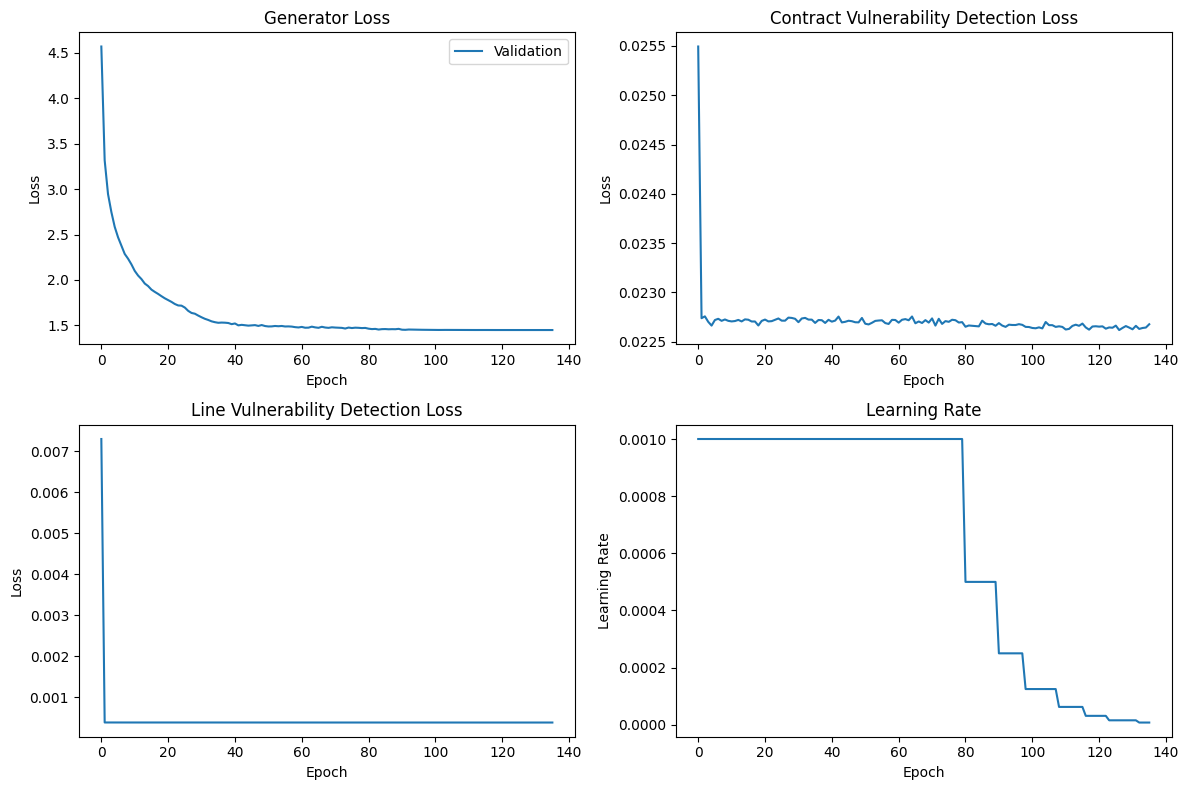

In [13]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 8))

# Plot generator loss
plt.subplot(2, 2, 1)
#plt.plot(trainer.training_history['train_loss'], label='Train')
plt.plot(trainer.training_history['val_loss'], label='Validation')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot vulnerability loss
plt.subplot(2, 2, 2)
plt.plot(trainer.training_history['contract_vuln_loss'])
plt.title('Contract Vulnerability Detection Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot synthetic loss
plt.subplot(2, 2, 3)
plt.plot(trainer.training_history['line_vuln_loss'])
plt.title('Line Vulnerability Detection Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot learning rate
plt.subplot(2, 2, 4)
plt.plot(trainer.training_history['learning_rate'])
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

plt.tight_layout()
plt.show()

In [16]:
# Load checkpoint
checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_epoch_20_model_v3.pt')  # Change this to your checkpoint file
checkpoint = torch.load(checkpoint_path)

# Load model states
model.load_state_dict(checkpoint['model_state_dict'])
model.generator.load_state_dict(checkpoint['generator_state_dict'])
model.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
model.decoder.load_state_dict(checkpoint['decoder_state_dict'])

# Load optimizer states
trainer.optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
trainer.optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
trainer.optimizer_decoder.load_state_dict(checkpoint['optimizer_decoder_state_dict'])

# Get the epoch to start from and best validation loss
start_epoch = checkpoint['epoch']
best_val_loss = checkpoint['val_loss']

print(f"Loaded checkpoint from epoch {start_epoch + 1}")
print(f"Previous validation loss: {best_val_loss:.4f}")

Loaded checkpoint from epoch 20
Previous validation loss: 0.0070


In [ ]:
# Training loop - start from the next epoch
num_epochs = 120

for epoch in range(start_epoch + 1, num_epochs):  # Start from the next epoch
    # Start timer for this epoch
    epoch_start_time = time.time()
    
    # Training
    g_loss, d_loss, decoder_loss = trainer.train_epoch()
    val_loss = trainer.validate()
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start_time
    
    # Print training progress
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Generator Loss: {g_loss:.4f}")
    print(f"Discriminator Loss: {d_loss:.4f}")
    print(f"Decoder Loss: {decoder_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Epoch Time: {epoch_time:.2f}s")
    
    # Save model checkpoint
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            # Model states
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'generator_state_dict': model.generator.state_dict(),
            'discriminator_state_dict': model.discriminator.state_dict(),
            'decoder_state_dict': model.decoder.state_dict(),
            
            # Optimizer states
            'optimizer_G_state_dict': trainer.optimizer_G.state_dict(),
            'optimizer_D_state_dict': trainer.optimizer_D.state_dict(),
            'optimizer_decoder_state_dict': trainer.optimizer_decoder.state_dict(),
            
            # Loss values
            'g_loss': g_loss,
            'd_loss': d_loss,
            'decoder_loss': decoder_loss,
            'val_loss': val_loss,
            
            # Model configuration
            'model_config': {
                'vocab_size': model.decoder.vocab_size,
                'max_length': model.decoder.max_length
            },
            
            # Training metadata
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'epoch_time': epoch_time
        }
        
        # Save regular checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}_model_v3.pt')
        torch.save(checkpoint, checkpoint_path)
        print(f"Saved checkpoint for epoch {epoch+1}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(checkpoint_dir, 'best_model_v3.pt')
            torch.save(checkpoint, best_model_path)
            print(f"New best model saved with validation loss: {val_loss:.4f}")

print("\nTraining completed!")
print(f"Best validation loss: {best_val_loss:.4f}")


Starting training epoch...


In [ ]:
print('Done')

NOTES:

1. Input Processing:
Initial input: [32, 512] (batch_size=32, sequence_length=512)
After embedding: [32, 512, 512] (batch_size=32, sequence_length=512, embedding_dim=512)
This is correct because the embedding layer converts each token to a 512-dimensional vector

2. Path Embeddings Processing:
Initial path embeddings: [32, 768] (batch_size=32, code2vec_dim=768)
After path embedding layer: [32, 512] (batch_size=32, transformer_dim=512)
The linear layer converts from code2vec's 768 dimensions to transformer's 512 dimensions
After expansion: [32, 512, 512] (batch_size=32, sequence_length=512, transformer_dim=512)
The path embeddings are expanded to match the sequence length

3. Final Shape:
[32, 512, 512] (batch_size=32, sequence_length=512, transformer_dim=512)
This is the correct shape for the transformer layers


In [15]:
checkpoint = {
    # Model states
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'generator_state_dict': model.generator.state_dict(),
    'discriminator_state_dict': model.discriminator.state_dict(),
    'decoder_state_dict': model.decoder.state_dict(),
    
    # Optimizer states
    'optimizer_G_state_dict': trainer.optimizer_G.state_dict(),
    'optimizer_D_state_dict': trainer.optimizer_D.state_dict(),
    'optimizer_decoder_state_dict': trainer.optimizer_decoder.state_dict(),
    
    # Loss values
    'g_loss': g_loss,
    'd_loss': d_loss,
    'decoder_loss': decoder_loss,
    'val_loss': val_loss,
    
    # Model configuration
    'model_config': {
        #'d_model': model.d_model,
        'vocab_size': model.decoder.vocab_size,
        'max_length': model.decoder.max_length
    },
    
    # Training metadata
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'epoch_time': epoch_time
}

# Save regular checkpoint
checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}_model_v3.pt')
torch.save(checkpoint, checkpoint_path)
print(f"Saved checkpoint for epoch {epoch+1}")

Saved checkpoint for epoch 10


In [25]:
print(f"Epoch [{epoch}/{num_epochs}]")
print(f"Generator Loss: {g_loss:.4f}")
print(f"Discriminator Loss: {d_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

Epoch [119/120]
Generator Loss: 10.5703
Discriminator Loss: 0.0062
Validation Loss: 0.0002


## Save model:

In [ ]:
torch.save({
    'epoch': 100,
    'model_state_dict': model.state_dict(),
    #'optimizer_G_state_dict': trainer.optimizer_G.state_dict(),
    #'optimizer_D_state_dict': trainer.optimizer_D.state_dict(),
    'gen_loss': model.gen_loss,
    'synth_loss': model.synth_loss,
    'vul_loss': model.vul_loss,
    'val_loss': model.val_loss,
    'model_config': {
        'd_model': 768,
    }
}, 'final_model_v1_512.pt')

In [21]:
# After training loop
# Save the final model and training state


# If you want to save just the model for inference
torch.save(model.state_dict(), 'model_weights_v1_512.pt')

# If you want to save the entire model
torch.save(model, 'full_model_v1_512.pt')

In [16]:
# Save model with additional information
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_G_state_dict': trainer.optimizer_G.state_dict(),
    'optimizer_D_state_dict': trainer.optimizer_D.state_dict(),
    'g_loss': g_loss,
    'd_loss': d_loss,
    'val_loss': val_loss,
    'model_config': {
        'd_model': 768
    },
    'training_config': {
        'learning_rate': 0.0002,
        'beta1': 0.5,
        'batch_size': 32
    },
    'training_history': {
        'g_losses': g_loss,  # List of generator losses
        'd_losses': d_loss,  # List of discriminator losses
        'val_losses': val_loss  # List of validation losses
    }
}, 'final_model_v4_with_history.pt')

# Load Model:

In [10]:
# Load the full training state
checkpoint = torch.load('final_model_v4.pt')
model = SmartContractVulnerabilityGAN(**checkpoint['model_config'])
model.load_state_dict(checkpoint['model_state_dict'])
model = model.cuda() 

# Initialize trainer with loaded model
trainer = VulnerabilityDetectionTrainer(
    model,
    train_dataloader,
    val_dataloader
)

# Load optimizer states if needed
trainer.optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
trainer.optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])


In [21]:
# Or if you just want to load the model weights
model = SmartContractVulnerabilityGAN(d_model=768)
model.load_state_dict(torch.load('model_weights.pt'))
model = model.cuda()  # Move to GPU if needed


In [ ]:
# Or if you saved the entire model
model = torch.load('full_model.pt')
model = model.cuda()  # Move to GPU if needed

## Model Exploration:

In [13]:
print("Type of model:", type(model))

# If it's a SmartContractVulnerabilityGAN object, we can inspect its components directly
print("\nModel Components:")
print("-" * 50)

# Print model attributes
print("\nModel Attributes:")
for attr in dir(model):
    if not attr.startswith('_'):  # Skip private attributes
        print(f"- {attr}")

# Print model structure
print("\nModel Structure:")
print(model)


Type of model: <class 'model.SmartContractVulnerabilityGAN'>

Model Components:
--------------------------------------------------

Model Attributes:
- T_destination
- add_module
- apply
- bfloat16
- buffers
- call_super_init
- children
- codebert
- compile
- cpu
- cuda
- decode_embeddings
- decoder
- discriminator
- double
- dump_patches
- eval
- extra_repr
- float
- forward
- generate_code
- generator
- get_buffer
- get_extra_state
- get_parameter
- get_submodule
- half
- ipu
- load_state_dict
- modules
- named_buffers
- named_children
- named_modules
- named_parameters
- parameters
- register_backward_hook
- register_buffer
- register_forward_hook
- register_forward_pre_hook
- register_full_backward_hook
- register_full_backward_pre_hook
- register_load_state_dict_post_hook
- register_module
- register_parameter
- register_state_dict_pre_hook
- requires_grad_
- set_extra_state
- share_memory
- state_dict
- to
- to_empty
- tokenizer
- train
- training
- transformer
- type
- xpu
- zer

In [14]:
print("\nModel State Dict:")
for key in model.state_dict().keys():
    print(f"- {key}")


Model State Dict:
- codebert.embeddings.word_embeddings.weight
- codebert.embeddings.position_embeddings.weight
- codebert.embeddings.token_type_embeddings.weight
- codebert.embeddings.LayerNorm.weight
- codebert.embeddings.LayerNorm.bias
- codebert.encoder.layer.0.attention.self.query.weight
- codebert.encoder.layer.0.attention.self.query.bias
- codebert.encoder.layer.0.attention.self.key.weight
- codebert.encoder.layer.0.attention.self.key.bias
- codebert.encoder.layer.0.attention.self.value.weight
- codebert.encoder.layer.0.attention.self.value.bias
- codebert.encoder.layer.0.attention.output.dense.weight
- codebert.encoder.layer.0.attention.output.dense.bias
- codebert.encoder.layer.0.attention.output.LayerNorm.weight
- codebert.encoder.layer.0.attention.output.LayerNorm.bias
- codebert.encoder.layer.0.intermediate.dense.weight
- codebert.encoder.layer.0.intermediate.dense.bias
- codebert.encoder.layer.0.output.dense.weight
- codebert.encoder.layer.0.output.dense.bias
- codebert.e

In [15]:
print("\nParameter Shapes:")
for name, param in model.named_parameters():
    print(f"- {name}: {param.shape}")


Parameter Shapes:
- codebert.embeddings.word_embeddings.weight: torch.Size([50265, 768])
- codebert.embeddings.position_embeddings.weight: torch.Size([514, 768])
- codebert.embeddings.token_type_embeddings.weight: torch.Size([1, 768])
- codebert.embeddings.LayerNorm.weight: torch.Size([768])
- codebert.embeddings.LayerNorm.bias: torch.Size([768])
- codebert.encoder.layer.0.attention.self.query.weight: torch.Size([768, 768])
- codebert.encoder.layer.0.attention.self.query.bias: torch.Size([768])
- codebert.encoder.layer.0.attention.self.key.weight: torch.Size([768, 768])
- codebert.encoder.layer.0.attention.self.key.bias: torch.Size([768])
- codebert.encoder.layer.0.attention.self.value.weight: torch.Size([768, 768])
- codebert.encoder.layer.0.attention.self.value.bias: torch.Size([768])
- codebert.encoder.layer.0.attention.output.dense.weight: torch.Size([768, 768])
- codebert.encoder.layer.0.attention.output.dense.bias: torch.Size([768])
- codebert.encoder.layer.0.attention.output.La

In [21]:
print("\nModel Configuration:")
print(f"- d_model: {model.d_model if hasattr(model, 'd_model') else 'N/A'}")
print(f"- vocab_size: {model.decoder.vocab_size if hasattr(model, 'decoder') else 'N/A'}")
print(f"- max_length: {model.decoder.max_length if hasattr(model, 'decoder') else 'N/A'}")


Model Configuration:
- d_model: N/A
- vocab_size: 50000
- max_length: 512


In [22]:
if hasattr(model, 'generator'):
    print("\nGenerator Architecture:")
    print(model.CodeDecoder)


Generator Architecture:


AttributeError: 'SmartContractVulnerabilityGAN' object has no attribute 'CodeDecoder'

### This is a GAN (Generative Adversarial Network) combined with a Transformer architecture for smart contract vulnerability detection.

#### Here's the technical breakdown:
#### 1. Architecture Components:
-Transformer Encoder: Processes smart contract code using self-attention
-Generator: Creates synthetic vulnerable code patterns
-Discriminator: Distinguishes between real and synthetic vulnerabilities

#### 2. Input Processing:
-Takes smart contract code and its AST (Abstract Syntax Tree) paths
-Uses CodeBERT to generate embeddings (768-dimensional vectors)
-Processes both contract code and path information

#### 3. Training Process:
3.1. Generator Training:
-Takes random noise and contract embeddings
-Generates synthetic vulnerable code patterns
-Tries to fool the discriminator

3.2. Discriminator Training:
-Takes real contract embeddings and generator outputs
-Learns to distinguish real from synthetic vulnerabilities
-Uses binary classification (real/fake)

#### 4. Output:
-Vulnerability scores for input contracts
-Synthetic vulnerable code patterns for training
-Binary classification of real vs. synthetic vulnerabilities

#### The model essentially learns to:
-Understand code patterns through the transformer
-Generate realistic vulnerable code examples
-Detect vulnerabilities in real contracts
-Improve detection through adversarial training

#### This approach combines the strengths of:
Transformers for code understanding
GANs for synthetic data generation
Binary classification for vulnerability detection

# 3. Usage:

In [27]:
# For a single contract
results = trainer.predict(validation_dataset[0])  # Pass a single contract's data

print(f"Vulnerability Score: {results['vulnerability_score']:.4f}")
print(f"Synthetic Score: {results['synthetic_score']:.4f}")
print(f"Is Vulnerable: {results['is_vulnerable']}")
print(f"Is Synthetic: {results['is_synthetic']}")

AttributeError: 'SmartContractTrainer' object has no attribute 'predict'

In [44]:
import torch
from model import SmartContractTransformer
from train import Discriminator

def load_trained_model(checkpoint_path, device='cuda:1'):
    """
    Load the trained model and discriminator from checkpoint
    """
    # Initialize model and discriminator
    model = SmartContractTransformer()
    discriminator = Discriminator()
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load state dicts
    model.load_state_dict(checkpoint['model_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    
    # Move to device
    model = model.to(device)
    discriminator = discriminator.to(device)
    
    # Set to eval mode
    model.eval()
    discriminator.eval()
    
    return model, discriminator

def analyze_contract(contract_data, model, discriminator, tokenizer=None, device='cuda:1'):
    """
    Analyze a smart contract for vulnerabilities and generate synthetic version
    """
    # Move input data to device
    input_ids = contract_data['input_ids'].unsqueeze(0).to(device)
    attention_mask = contract_data['attention_mask'].unsqueeze(0).to(device)
    path_input_ids = contract_data['path_input_ids'].unsqueeze(0).to(device)
    path_attention_mask = contract_data['path_attention_mask'].unsqueeze(0).to(device)
    
    # Decode original contract if tokenizer is provided
    original_text = None
    if tokenizer is not None:
        original_text = tokenizer.decode(input_ids[0].cpu().tolist())
    
    with torch.no_grad():
        # Get vulnerability score
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            path_input_ids=path_input_ids,
            path_attention_mask=path_attention_mask,
            target_ids=None
        )
        
        # Get discriminator predictions
        vuln_pred, synth_pred = discriminator(outputs['encoder_output'])
        vulnerability_score = torch.sigmoid(vuln_pred).item()
        synthetic_score = torch.sigmoid(synth_pred).item()
        
        result = {
            'vulnerability_score': vulnerability_score,
            'synthetic_score': synthetic_score,
            'is_vulnerable': vulnerability_score > 0.5,
            'is_synthetic': synthetic_score > 0.5,
            'original_contract': {
                'text': original_text,
                'input_ids': input_ids[0].cpu().tolist()
            }
        }
        
        # Generate synthetic contract
        synthetic_outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            path_input_ids=path_input_ids,
            path_attention_mask=path_attention_mask,
            target_ids=None
        )
        
        # Get the generated sequence
        generated_sequence = synthetic_outputs['generated_sequence']
        
        # Get discriminator predictions for synthetic contract
        synth_vuln_pred, synth_synth_pred = discriminator(synthetic_outputs['encoder_output'])
        synth_vulnerability_score = torch.sigmoid(synth_vuln_pred).item()
        synth_synthetic_score = torch.sigmoid(synth_synth_pred).item()
        
        result['synthetic_contract'] = {
            'sequence': generated_sequence[0].cpu().tolist(),
            'vulnerability_score': synth_vulnerability_score,
            'synthetic_score': synth_synthetic_score,
            'is_vulnerable': synth_vulnerability_score > 0.5,
            'is_synthetic': synth_synthetic_score > 0.5
        }
        
        # If tokenizer is provided, decode the synthetic contract
        if tokenizer is not None:
            synthetic_tokens = result['synthetic_contract']['sequence']
            result['synthetic_contract']['text'] = tokenizer.decode(synthetic_tokens)
        
        return result


In [45]:
# Load the trained model
checkpoint_path = 'checkpoints_v1/latest_model.pt'  # or 'best_model_epoch_X.pt'
model_loaded, discriminator = load_trained_model(checkpoint_path)

In [58]:
contract_data = val_dataset[9]

In [59]:
# Analyze the contract
results = analyze_contract(contract_data, model_loaded, discriminator, tokenizer)

# Print results
print("\nContract Analysis Results:")
print("-" * 50)
print(f"Vulnerability Score: {results['vulnerability_score']:.4f}")
print(f"Synthetic Score: {results['synthetic_score']:.4f}")
print(f"Vulnerability Status: {'Vulnerable' if results['is_vulnerable'] else 'Safe'}")
print(f"Synthetic Status: {'Synthetic' if results['is_synthetic'] else 'Real'}")

# Print original contract
if results['original_contract']['text']:
    print("\nOriginal Contract:")
    print("-" * 50)
    print(results['original_contract']['text'])
    

print("\nSynthetic Contract Analysis:")
print("-" * 50)
print(f"Vulnerability Score: {results['synthetic_contract']['vulnerability_score']:.4f}")
print(f"Synthetic Score: {results['synthetic_contract']['synthetic_score']:.4f}")
print(f"Vulnerability Status: {'Vulnerable' if results['synthetic_contract']['is_vulnerable'] else 'Safe'}")
print(f"Synthetic Status: {'Synthetic' if results['synthetic_contract']['is_synthetic'] else 'Real'}")

if 'text' in results['synthetic_contract']:
    print("\nGenerated Synthetic Contract:")
    print("-" * 50)
    print(results['synthetic_contract']['text'])


Contract Analysis Results:
--------------------------------------------------
Vulnerability Score: 0.0151
Synthetic Score: 0.7673
Vulnerability Status: Safe
Synthetic Status: Synthetic

Original Contract:
--------------------------------------------------
<s>/**
 *Submitted for verification at Etherscan.io on 2020-11-22
*/

// SPDX-License-Identifier: MIT + WTFPL
// File: contracts/uniswapv2/interfaces/IUniswapV2Factory.sol

pragma solidity >=0.5.0;

interface IUniswapV2Factory {
    event PairCreated(address indexed token0, address indexed token1, address pair, uint);

    function feeTo() external view returns (address);
    function feeToSetter() external view returns (address);
    function migrator() external view returns (address);

    function getPair(address tokenA, address tokenB) external view returns (address pair);
    function allPairs(uint) external view returns (address pair);
    function allPairsLength() external view returns (uint);

    function createPair(address 